In [2]:
import os
import sys
sys.path.append(os.path.join(os.getcwd(), '../../../'))

os.environ['HF_ENDPOINT'] = 'https://hf-mirror.com'
os.environ['CUDA_VISIBLE_DEVICES'] = '3'
os.environ['HOME'] = '/data25/wuqin'

In [3]:
import torch
from src.arguments import ModelArguments, DataArguments
from src.model.model import MMEBModel
from src.model.processor import load_processor, QWEN2_VL, VLM_IMAGE_TOKENS, Qwen2_VL_process_fn
from src.utils import batch_to_device
from experiments.examples.qwen2vl.utils import show_tensor_image, split_to_grid, show_grid, tensor2pil
from experiments.examples.qwen2vl.vggt_utils import load_and_preprocess_images
import logging

logging.basicConfig(level=logging.WARNING)


class VLM2VecWithPatchEmbeddings(MMEBModel):
    """扩展VLM2Vec模型以获取patch embeddings"""

    def encode_mm_with_patches(self, images, texts):
        """
        编码多模态输入并返回patch embeddings

        Args:
            images: 图像输入
            texts: 文本输入

        Returns:
            tuple: (pooled_embeddings, patch_embeddings)
        """
        # 使用VLM2Vec的处理器处理输入
        processor_inputs = {
            "text": texts,
            "images": images,
        }
        inputs = Qwen2_VL_process_fn(processor_inputs, self.processor)
        inputs = batch_to_device(inputs, "cuda")

        # 获取模型的隐藏状态
        with torch.no_grad():
            hidden_states = self.encoder(**inputs, return_dict=True, output_hidden_states=True)
            hidden_states = hidden_states.hidden_states[-1]  # 最后一层的隐藏状态

        # 获取pooled embeddings
        pooled_output = self._pooling(hidden_states, inputs['attention_mask'])

        # 获取patch embeddings (图像token对应的隐藏状态)
        # 找到图像token的位置
        image_token_id = self.encoder.config.image_token_id
        image_mask = inputs['input_ids'] == image_token_id

        # 获取图像patch的隐藏状态
        patch_embeddings = hidden_states[image_mask]  # [num_patches, hidden_dim]

        return pooled_output, patch_embeddings
# 初始化模型
model_args = ModelArguments(
    model_name='VLM2Vec/VLM2Vec-V2.0',
    pooling='last',
    normalize=True,
    model_backbone='qwen2_vl',
    lora=True
)
data_args = DataArguments()

processor = load_processor(model_args, data_args)
model = VLM2VecWithPatchEmbeddings.load(model_args)
model.processor = processor  # 保存processor引用
model = model.to('cuda', dtype=torch.bfloat16)
model = model.eval()

/data25/wuqin/miniforge3/envs/vlm2vec/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[2025-07-31 08:03:23,449] DEBUG [git.cmd:1270] Popen(['git', 'version'], cwd=/data25/wuqin/projects/VLM2Vec/experiments/examples/qwen2vl, stdin=None, shell=False, universal_newlines=False)
[2025-07-31 08:03:23,458] DEBUG [git.cmd:1270] Popen(['git', 'version'], cwd=/data25/wuqin/projects/VLM2Vec/experiments/examples/qwen2vl, stdin=None, shell=False, universal_newlines=False)
/data25/wuqin/miniforge3/envs/vlm2vec/lib/python3.11/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
[2025-07-31 08:03:24,791] DEBUG [matplotlib:342]

DropoutAddRMSNorm of flash_attn is not installed!!!


[2025-07-31 08:03:24,941] DEBUG [matplotlib:342] CACHEDIR=/data25/wuqin/.cache/matplotlib
[2025-07-31 08:03:24,946] DEBUG [matplotlib.font_manager:1635] Using fontManager instance from /data25/wuqin/.cache/matplotlib/fontlist-v390.json
[2025-07-31 08:03:25,303] INFO [src.utils:21] Loading processor from: VLM2Vec/VLM2Vec-V2.0
[2025-07-31 08:03:25,311] DEBUG [urllib3.connectionpool:1049] Starting new HTTPS connection (1): hf-mirror.com:443
[2025-07-31 08:03:26,215] DEBUG [urllib3.connectionpool:544] https://hf-mirror.com:443 "HEAD /VLM2Vec/VLM2Vec-V2.0/resolve/main/preprocessor_config.json HTTP/1.1" 307 0
[2025-07-31 08:03:26,629] DEBUG [urllib3.connectionpool:544] https://hf-mirror.com:443 "HEAD /api/resolve-cache/models/VLM2Vec/VLM2Vec-V2.0/e39ff079b8275ef876d3656da8c0bddbff3c4dde/preprocessor_config.json HTTP/1.1" 200 0
[2025-07-31 08:03:26,912] DEBUG [urllib3.connectionpool:544] https://hf-mirror.com:443 "HEAD /VLM2Vec/VLM2Vec-V2.0/resolve/main/tokenizer_config.json HTTP/1.1" 307 0
[

In [4]:
from vggt_utils import load_and_preprocess_images
img = load_and_preprocess_images(["/data25/wuqin/projects/FlagEmbedding/research/visual_bge/vl_query_samples/test6/IMG_1786.jpg"])
print(img.shape)

torch.Size([1, 3, 392, 518])


[2025-07-30 05:13:22,422] DEBUG [matplotlib.pyplot:497] Loaded backend module://matplotlib_inline.backend_inline version unknown.
[2025-07-30 05:13:22,425] DEBUG [matplotlib.pyplot:497] Loaded backend module://matplotlib_inline.backend_inline version unknown.
[2025-07-30 05:13:22,429] DEBUG [matplotlib.font_manager:1471] findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
[2025-07-30 05:13:22,430] DEBUG [matplotlib.font_manager:1483] findfont: score(FontEntry(fname='/data25/wuqin/miniforge3/envs/vlm2vec/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif-Italic.ttf', name='DejaVu Serif', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
[2025-07-30 05:13:22,431] DEBUG [matplotlib.font_manager:1483] findfont: score(FontEntry(fname='/data25/wuqin/miniforge3/envs/vlm2vec/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizOneSymReg.ttf', name='STIXSizeOneSym', style='nor

[2025-07-30 05:13:22,471] DEBUG [matplotlib.font_manager:1483] findfont: score(FontEntry(fname='/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf', name='DejaVu Sans', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 0.05
[2025-07-30 05:13:22,471] DEBUG [matplotlib.font_manager:1483] findfont: score(FontEntry(fname='/usr/share/fonts/truetype/liberation/LiberationMono-Bold.ttf', name='Liberation Mono', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
[2025-07-30 05:13:22,472] DEBUG [matplotlib.font_manager:1483] findfont: score(FontEntry(fname='/usr/share/texmf/fonts/opentype/public/lm/lmroman9-regular.otf', name='Latin Modern Roman', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[2025-07-30 05:13:22,472] DEBUG [matplotlib.font_manager:1483] findfont: score(FontEntry(fname='/usr/share/fonts/truetype/liberation/LiberationMono-BoldItalic.ttf', name='Liberation Mono', styl

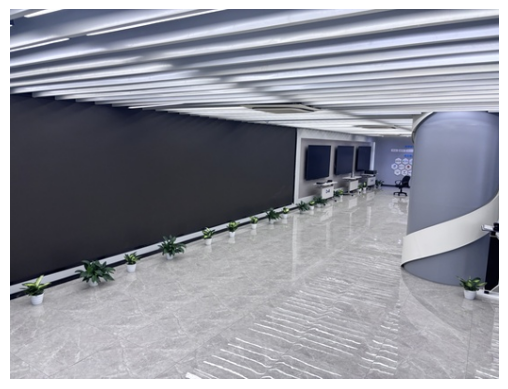

In [5]:
from utils import show_tensor_image
show_tensor_image(img)

## 多模态推理

输入图像文本对，将最后一层全局的 [cls] token（$1\times d$）与图片 patch 对应的 hidden states （$\frac{H}{p}\times\frac{W}{p}\times d$）进行相似度计算

In [11]:
from utils import tensor2pil
prompt = "找出图片中的绿植部分"
with torch.no_grad():
    text = [f'{VLM_IMAGE_TOKENS[QWEN2_VL]} {prompt}']
    image = tensor2pil(img[0])
    query_emb, candi_embs = model.encode_mm_with_patches(images=[image], texts=text)

# 归一化embeddings
candi_embs = torch.nn.functional.normalize(candi_embs, dim=-1)
query_emb = torch.nn.functional.normalize(query_emb, dim=-1)
print(f"查询embedding形状: {query_emb.shape}, patch embeddings形状: {candi_embs.shape}")

查询embedding形状: torch.Size([1, 1536]), patch embeddings形状: torch.Size([252, 1536])


In [12]:
sims = model.compute_similarity(query_emb, candi_embs)
sims = sims.float()
sims = sims.view(14, 18)
print(sims.shape)

torch.Size([14, 18])


torch.Size([252, 3, 28, 28])
Grid shape: 252 blocks of size 28x28


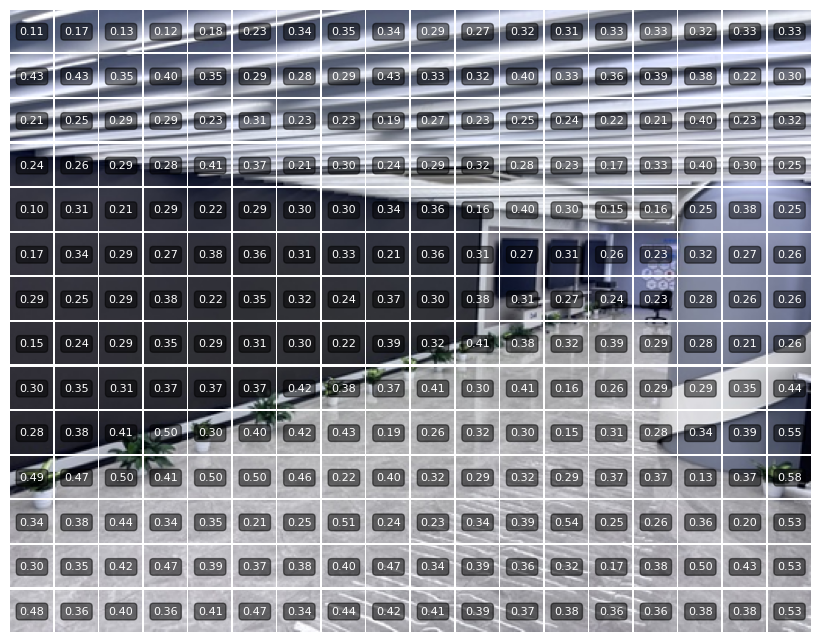

In [13]:
from utils import show_grid, split_to_grid
grid = split_to_grid(img[0], (14, 18))
print(grid.shape)
show_grid(grid, sims, grid_size=(14, 18))

## 图文多模态与图片单模态检索

图文多模态输出的 [cls] token 与图片单模态输出的图片 patch 对应的 hidden states 进行相似度计算

torch.Size([1, 1536]) torch.Size([252, 1536])
torch.Size([14, 18])
torch.Size([14, 18, 28, 28, 3])
Grid shape: 14 blocks of size 28x28


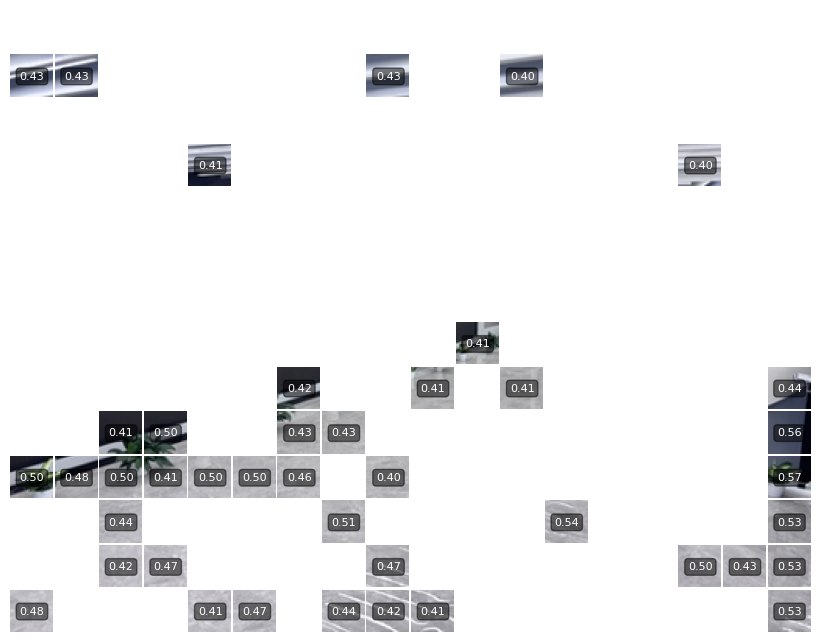

In [36]:
with torch.no_grad():
    query_emb, _ = model.encode_mm_with_patches(images=[image], texts=text)
    _, candi_embs = model.encode_mm_with_patches(images=[image], texts=[f'{VLM_IMAGE_TOKENS[QWEN2_VL]} '])
candi_embs = torch.nn.functional.normalize(candi_embs, dim=-1)
query_emb = torch.nn.functional.normalize(query_emb, dim=-1)
print(query_emb.shape, candi_embs.shape)
sims = model.compute_similarity(query_emb, candi_embs)
sims = sims.reshape(14, 18).float().cpu()
print(sims.shape)
grid = split_to_grid(img[0], (14, 18))
print(grid.shape)
show_grid(grid, sims, mask=sims>0.4)